### Function $f(x)$:
$ f(x) = \sum_{i=1}^{n-1} [4(x_i^2 - x_{i+1})^2 + (x_i - 1)^2] $

- **Minimizer and Minimum Function Value:**
  - The minimum of $f(x)$ occurs when $x_i = 1$ for all $i$.
  - The minimum function value is $f_{\text{min}} = 0$.

- **Convexity:**
  - Each term in the summation is convex (quadratic), and the sum of convex functions is also convex. Therefore, $f(x)$ is convex.

### Function $g(x)$:
$ g(x) = \sum_{i=1}^{n} [(x_{1} - x_{i}^2)^2 + (x_i - 1)^2] $

- **Minimizer and Minimum Function Value:**
  - The global minimum occurs when $x_i = 1$ for all $i$.
  - The minimum function value is $g_{\text{min}} = 0$.

- **Convexity:**
  - Each term in the summation is convex (quadratic), and the sum of convex functions is also convex. Therefore, $g(x)$ is convex.

### Suitable Initial Choice of $B_0$:
- A common choice for $B_0$ is the identity matrix $(I$) or a scaled version of it. This is because $B_0$ is used as an initial approximation to the inverse Hessian matrix.
- Using the identity matrix as the initial guess implies that initially, the algorithm assumes the objective function is quadratic, which is a reasonable assumption when starting the optimization process.
- A suitable choice for intial B can be any diagonal matrix which is positive definite or any multiple of the identity matrix which is positive definite.

### Convexity Justification:
Convexity is crucial for the BFGS algorithm to converge reliably. Both $f(x)$ and $g(x)$ are convex functions, which ensures the algorithm's stability and convergence toward the global minimum.

In summary, the minimizers for both $f(x)$ and $g(x)$ are achieved when $x_i = 1$ for all $i$, and the minimum function values are $f_{\text{min}} = 0$ and $g_{\text{min}} = 0$ respectively. Both functions are convex, supporting the application of the BFGS algorithm. A suitable initial choice for $B_0$ is the identity matrix $I$.


In [24]:
#Let us now check the time taken for computing the inverse of a matrix A
from timeit import default_timer as timer
import numpy as np

#create a random nxn matrix
n = 100
B = np.random.rand(n, n)
A = np.matmul(B,B.T) #Note: This construction ensures that A is symmetric
A = np.add(A, 0.001*np.identity(n)) #this diagonal perturbation helps to make the matrix positive definite

start_time = timer()
A_inv = np.linalg.inv(A)
end_time = timer()
print('Time taken to compute inverse of A:',end_time - start_time)

Time taken to compute inverse of A: 0.0008067740000115009


$\text{We can take a scalar multiple of identity matrix or a diagonal matrix as initial choice of B}$

$ \text{Implement the modules of BFGS method to solve the problem minx∈Rn f(x) where we have} $

 $f(x) = f(x_1, x_2, . . . , x_n)= \sum_{i=1}^{n-1}[4(x_i^2-x_{i+1})^2+(x_i-1)^2]
 \\ $
 $\text{Use backtracking line search with α
0 = 0.9, ρ = 0.5, γ = 0.5 in the implementation of BFGS method. Take the starting point to be }
x^0 = (0, 0, . . . , 0).$

In [ ]:
def evalf(x,n):
  assert type(x) is np.ndarray and len(x) == n
  fun_val = 0
  for i in range(n-1):
    fun_val = fun_val + 4*(x[i]**2 - x[i+1])**2 + (x[i] - 1)**2
  return fun_val

In [ ]:
def evalg(x,n):
  assert type(x) is np.ndarray and len(x) == n
  grad_list = [16*(x[0]**2 - x[1])*x[0] + 2*(x[0] -1)]
  for i in range(n-2):
     grad_list.append(16*(x[i+1]**2 - x[i+2])*x[i+1] + 2*(x[i+1] -1) - 8*(x[i]**2 - x[i+1]))
  grad_list.append(- 8*(x[n-2]**2 - x[n-1]))
  a=np.array(grad_list).reshape((n,1))
  return a

In [ ]:
def compute_steplength_backtracking(n,x, gradf, direction, alpha_start, rho, gamma):
  assert type(x) is np.ndarray and len(x) == n
  assert type(gradf) is np.ndarray and len(gradf) == n
  assert type(direction) is np.ndarray and len(gradf) == n
  assert type(alpha_start) is float and alpha_start>=0.
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0.

  alpha = alpha_start
  while evalf(x+alpha*direction,n)>evalf(x,n)+gamma*alpha*np.matmul(gradf.T,direction):
    alpha=rho*alpha

  return alpha

In [ ]:
BACKTRACKING_LINE_SEARCH = 1
CONSTANT_STEP_LENGTH=2
EXACT_LINE_SEARCH=3

In [ ]:
def BFGS_method(n,start_x,tol,*args):
  assert type(start_x) is np.ndarray  and len(start_x) == n
  assert type(tol) is float and tol>=0

  x=start_x
  g_x=evalg(x,n)
  B_k=np.identity(n)/4
  alpha_start=args[0]
  rho = args[1]
  gamma = args[2]

  k=0
  while (np.linalg.norm(g_x)>tol):
    p_k=-np.matmul(B_k,g_x)
    step_length=compute_steplength_backtracking(n,x, g_x, p_k, alpha_start, rho, gamma)

    x_initial=x
    x=x+np.multiply(step_length,p_k)

    s_k=x-x_initial
    y_k=evalg(x,n)-evalg(x_initial,n)
    u_k= 1/np.matmul(y_k.transpose(),s_k)

    B_1=np.eye(n)-u_k*np.matmul(s_k,y_k.transpose())
    B_2=np.eye(n)-u_k*np.matmul(y_k,s_k.transpose())

    B_k=np.matmul(np.matmul(B_1,B_k),B_2)+u_k*np.matmul(s_k,s_k.transpose())
    k=k+1
    g_x=evalg(x,n)
    #if k%1000==0:
      #print('iterations till now:',k)

  return x,evalf(x,n),k


$\text{ Take n ∈ {1000, 2500, 5000, 7500, 10000}, find minimizer of the objective function in each case and compute
the time taken by the BFGS} \\ \text{ method with backtracking line search. Tabulate the time taken by BFGS method
for each n.}$

In [ ]:
n_list=[1000,2500,5000,7500,10000]

In [ ]:
n_list=[1000,2500,5000,7500,10000]
alpha_start=0.9
rho=0.5
gamma=0.5
iteration_list=[]
time_taken_list=[]
for n in n_list:
  start_time=timer()
  x_start=np.array([0 for i in range(n)]).reshape((n,1))
  minimizer,minimum_val,iter=BFGS_method(n,x_start,1e-3,alpha_start,rho,gamma)
  end_time=timer()
  iteration_list.append(iter)
  time_taken_list.append(end_time-start_time)

  print('when n is :',n)
  print('minimim_value of function is:',minimum_val)
  print('number of iterations taken:',iter)
  print('time taken to solve:',end_time-start_time)
  print('minimizer is :',minimizer)

  print('\n********************************************************')


when n is : 1000
minimim_value of function is: [9.98794362e-09]
number of iterations taken: 57
time taken to solve: 21.698501163999936
minimizer is : [[0.99999949]
 [0.99999215]
 [0.99999996]
 [0.99999852]
 [0.99999758]
 [0.99999843]
 [0.99999979]
 [1.00000015]
 [0.99999979]
 [1.00000045]
 [1.00000143]
 [1.00000061]
 [0.99999975]
 [0.99999985]
 [0.99999959]
 [0.99999924]
 [0.99999903]
 [0.99999936]
 [0.99999979]
 [0.99999948]
 [0.9999991 ]
 [0.99999926]
 [0.9999993 ]
 [0.99999922]
 [0.99999937]
 [1.00000004]
 [1.0000008 ]
 [1.00000129]
 [1.0000013 ]
 [1.00000077]
 [0.99999971]
 [0.99999909]
 [0.99999978]
 [1.00000118]
 [1.00000143]
 [0.99999972]
 [0.99999761]
 [0.99999748]
 [1.00000008]
 [1.00000302]
 [1.00000319]
 [0.99999987]
 [0.99999713]
 [0.99999736]
 [1.00000158]
 [1.00000248]
 [1.00000098]
 [0.99999631]
 [1.00000143]
 [1.00000097]
 [0.99999915]
 [1.00000033]
 [1.00000002]
 [1.00000005]
 [1.00000005]
 [1.00000005]
 [1.00000005]
 [1.00000005]
 [1.00000005]
 [1.00000005]
 [1.000000

$\text{ while running the code, for n=7500 it took approx one hour and for n=10000 it was taking so long time and it was disconnected automatically so I wrote the results till n=7500}$

In [ ]:
time_taken_bfgs=[21.698501163999936,182.24241892400005,1175.6270615609997,3596.3528745410003]

$\text{Use Newton’s method to solve the problem minx∈Rn f(x) . In Newton’s method implementation, use backtracking line search with} \\  α_
0 = 0.9, ρ = 0.5, γ = 0.5. \\ \text{ Take the starting point to be x
0 = (0, 0, . . . , 0) in the
implementation of Newton’s Method.}
$

In [ ]:
def evalh(n, x):
  assert type(x) is np.ndarray and len(x) == n
  h = np.zeros((n,n))
  h[0][0] = 48*(x[0])**2 - 16*x[1] + 2
  h[0][1] = -16*x[0]
  for i in range(n-2):
    h[i+1][i+1] = 8 + 16*(x[i+1]**2 - x[i+2]) + 32*x[i+1]**2 +2
    h[i+1][i+2] = -16*x[i+1]
    h[i+1][i] = h[i][i+1]
  h[n-1][n-2] = h[n-2][n-1]
  h[n-1][n-1] = 8

  return h

In [ ]:
def newton_method(n,start_x,tol,*args):

  x=start_x
  gradf=evalg(x,n)
  hess=evalh(n,x)

  alpha_start=args[0]
  rho = args[1]
  gamma = args[2]
  p_k=-np.matmul(np.linalg.inv(hess),gradf)
  k=0
  while np.linalg.norm(gradf)>tol:
    p_k=-np.matmul(np.linalg.inv(hess),gradf)
    step_length=compute_steplength_backtracking(n,x, gradf, p_k, alpha_start, rho, gamma)
    x=x+step_length*p_k
    k=k+1
    gradf=evalg(x,n)
    hess=evalh(n,x)
    if k%10==0:
      print('norm  after ',k,'iterations is:',np.linalg.norm(gradf), 'and function value is:',evalf(x,n))
  return x, evalf(x,n),k



 Take n ∈ {1000, 2500, 5000, 7500, 10000}, find minimizer of the objective function in each case and compute
the time taken by } \\ \text{ the Newton’s method with backtracking line search. Tabulate the time taken by Newton’s
method for each n.}

In [ ]:
n_list=[1000,2500,5000,7500,10000]
alpha_start=0.9
rho=0.5
gamma=0.5
iteration_list_newton=[]
time_taken_list_newton=[]
print('Using Newtons method \n ***********************************')
for n in n_list:

  start_time=timer()
  x_start=np.array([0 for i in range(n)]).reshape((n,1))
  minimizer,minimum_val,iter=newton_method(n,x_start,1e-3,alpha_start,rho,gamma)
  end_time=timer()
  iteration_list_newton.append(iter)
  time_taken_list_newton.append(end_time-start_time)

  print('when n is :',n)
  print('minimim_value of function is:',minimum_val)
  print('number of iterations taken:',iter)
  print('time taken to solve:',end_time-start_time)
  print('minimizer is :',minimizer)

  print('\n********************************************************')

Using Newtons method 
 ***********************************
norm  after  10 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  20 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  30 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  40 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  50 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  60 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  70 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  80 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  90 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  100 iterations is: 102.37090973147649 and function value is: [578.17672422]
norm  after  110 iterations is: 102.37090973147649 and funct

KeyboardInterrupt: ignored

$\textbf{As we can see that after each iteration our norm and function value remains same which conclude that after each } \\ \textbf{ iteration we don't get any implement in our result towards optimal condition. So newton's method is not able to solve} \\ \textbf{ the problem but bfgs is able to solve the problem. So I stopped the runtime.  }$

Compare the time taken by BFGS method with backtracking line search against the time taken by Newton’s
method with backtracking line search $ \\ \text{ for each value of n. Plot the time taken by both methods vs n using
different colors. Comment on your observations.}$

$\text{As we saw that newton method is not able to solve the problem so we create a plot based on the values of n and time taken to solve bfgs method.}$

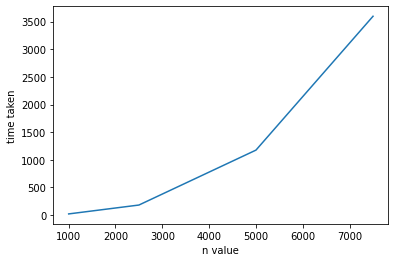

In [ ]:
import matplotlib.pyplot as plt
plt.plot(n_list[:-1],time_taken_bfgs)
plt.xlabel('n value')
plt.ylabel('time taken')
plt.show()

$\large \textbf{Observations:} \\ \text{As we can see that as soon as value of n increases , time taken to solve the problem also increases.}$

$\textbf{In this exercise we shall consider the following problem:} \\
q(x)=f(x_1,x_2,…,x_n)=\sum_{i=1}^n ((x_i-1)^2+(x_1-x_i^2)^2)$


$\text{ Use BFGS method to solve the problem minx∈Rn q(x). Use backtracking line search wit} h α_0 = 0.9, ρ = 0.5, γ =
0. \text{ in the implementation of BFGS method. Take the starting point to be }  \\ x^0=(0,0,0,....0)$

In [17]:
def evalf(x,n):
  assert type(x) is np.ndarray and len(x)==n
  return sum((x[i]-1)**2+(x[0]-x[i]**2)**2 for i in range(n))

In [18]:
def evalg(x,n):
  assert type(x) is np.ndarray and len(x)==n
  grad_list=[]
  grad_list.append(2*(x[0]-1)+2*(x[0]-x[0]**2)*(1-2*x[0])+sum(2*(x[0]-x[i]**2) for i in range(1,n)))
  for i in range(1,n):
    grad_list.append(2*(x[i]-1)-4*x[i]*(x[0]-x[i]**2))
  return np.array(grad_list).reshape(n,1)

In [19]:
def compute_steplength_backtracking(n,x, gradf, direction, alpha_start, rho, gamma):
  assert type(x) is np.ndarray and len(x) == n
  assert type(gradf) is np.ndarray and len(gradf) == n
  assert type(direction) is np.ndarray and len(gradf) == n
  assert type(alpha_start) is float and alpha_start>=0.
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0.

  alpha = alpha_start
  while evalf(x+alpha*direction,n)>evalf(x,n)+gamma*alpha*np.matmul(gradf.T,direction):
    alpha=rho*alpha

  return alpha

In [20]:
BACKTRACKING_LINE_SEARCH = 1
CONSTANT_STEP_LENGTH=2
EXACT_LINE_SEARCH=3

In [21]:
def BFGS_method(n,start_x,tol,*args):
  assert type(start_x) is np.ndarray  and len(start_x) == n
  assert type(tol) is float and tol>=0

  x=start_x
  g_x=evalg(x,n)
  B_k=np.identity(n)/4
  alpha_start=args[0]
  rho = args[1]
  gamma = args[2]

  k=0
  while (np.linalg.norm(g_x)>tol):
    p_k=-np.matmul(B_k,g_x)
    step_length=compute_steplength_backtracking(n,x, g_x, p_k, alpha_start, rho, gamma)

    x_initial=x
    x=x+np.multiply(step_length,p_k)

    s_k=x-x_initial
    y_k=evalg(x,n)-evalg(x_initial,n)
    u_k= 1/np.matmul(y_k.transpose(),s_k)

    B_1=np.eye(n)-u_k*np.matmul(s_k,y_k.transpose())
    B_2=np.eye(n)-u_k*np.matmul(y_k,s_k.transpose())

    B_k=np.matmul(np.matmul(B_1,B_k),B_2)+u_k*np.matmul(s_k,s_k.transpose())
    k=k+1
    g_x=evalg(x,n)
    #if k%1000==0:
      #print('iterations till now:',k)

  return x,evalf(x,n),k

In [22]:
n_list=[1000,2500,5000,7500,10000]

In [25]:
n_list=[1000,2500,5000,7500,10000]
alpha_start=0.9
rho=0.5
gamma=0.5
iteration_list=[]
time_taken_list=[]
for n in n_list:
  start_time=timer()
  x_start=np.array([0 for i in range(n)]).reshape((n,1))
  minimizer,minimum_val,iter=BFGS_method(n,x_start,1e-3,alpha_start,rho,gamma)
  end_time=timer()
  iteration_list.append(iter)
  time_taken_list.append(end_time-start_time)

  print('when n is :',n)
  print('minimim_value of function is:',minimum_val)
  print('number of iterations taken:',iter)
  print('time taken to solve:',end_time-start_time)
  print('minimizer is :',minimizer)

  print('\n********************************************************')


when n is : 1000
minimim_value of function is: [3.06938807e-11]
number of iterations taken: 11
time taken to solve: 3.152911507999761
minimizer is : [[0.99999964]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.99999988]
 [0.9999998

KeyboardInterrupt: 

In [26]:
from tabulate import tabulate

In [27]:
table = [["n", " bfgs timing "]]
for i in  range(len(time_taken_list)):
    table.append([n_list[i] , time_taken_list[i] ])
print(tabulate(table, headers = 'firstrow',tablefmt="grid"))

+------+-----------------+
|    n |    bfgs timing  |
+======+=================+
| 1000 |         3.15291 |
+------+-----------------+


In [28]:
time_taken_bfgs=[3.42857,34.7538,199.974,715.442,1524.92]

In [29]:
def evalh(x,n):
  assert type(x) is np.ndarray and len(x) == n
  hessn = np.zeros((n,n))
  hessn[0][0] = 2 -4*(x[0] - x[0]**2) + 2*(1- 2*x[0])**2
  if n>=2:
    for i in range(1,n):
      hessn[0][0] = hessn[0][0] + 2
      hessn[0][i] = -4*x[i]

  for i in range(1,n):
    hessn[i][i] = 2 - 4*(x[0] - x[i]**2) + 8*(x[i]**2)
    hessn[i][0] = hessn[0][i]

  return hessn

In [30]:
def newton_method(n,start_x,tol,*args):

  x=start_x
  gradf=evalg(x,n)
  hess=evalh(x,n)

  alpha_start=args[0]
  rho = args[1]
  gamma = args[2]
  p_k=-np.matmul(np.linalg.inv(hess),gradf)
  k=0
  while np.linalg.norm(gradf)>tol:
    p_k=-np.matmul(np.linalg.inv(hess),gradf)
    step_length=compute_steplength_backtracking(n,x, gradf, p_k, alpha_start, rho, gamma)
    x=np.add(x,np.multiply(step_length,p_k))
    k=k+1
    gradf=evalg(x,n)
    hess=evalh(x,n)
  return x, evalf(x,n),k

In [31]:
n_list=[1000,2500,5000,7500,10000]
alpha_start=0.9
rho=0.5
gamma=0.5
iteration_list_newton=[]
time_taken_list_newton=[]
print('Using Newtons method \n ***********************************')
for n in n_list:

  start_time=timer()
  x_start=np.array([0 for i in range(n)]).reshape((n,1))
  minimizer,minimum_val,iter=newton_method(n,x_start,1e-3,alpha_start,rho,gamma)
  end_time=timer()
  iteration_list_newton.append(iter)
  time_taken_list_newton.append(end_time-start_time)

  print('when n is :',n)
  print('minimim_value of function is:',minimum_val)
  print('number of iterations taken:',iter)
  print('time taken to solve:',end_time-start_time)
  print('minimizer is :',minimizer)

  print('\n********************************************************')

Using Newtons method 
 ***********************************
when n is : 1000
minimim_value of function is: [1.47390137e-11]
number of iterations taken: 9
time taken to solve: 1.9421701900000699
minimizer is : [[0.99999973]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999999 ]
 [0.9999

KeyboardInterrupt: 

In [32]:
table = [["n", " newton method timing "]]
for i in  range(len(time_taken_list_newton)):
    table.append([n_list[i] , time_taken_list_newton[i] ])
print(tabulate(table, headers = 'firstrow',tablefmt="grid"))

+------+--------------------------+
|    n |    newton method timing  |
+======+==========================+
| 1000 |                  1.94217 |
+------+--------------------------+


In [33]:
time_taken_newton=[2.99308,19.9596,133.638,412.435,1041.65]

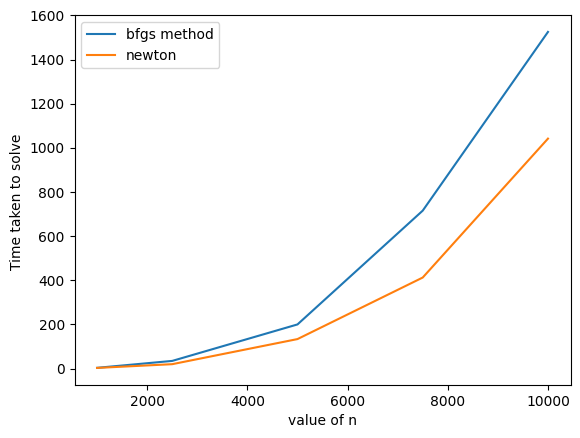

In [34]:
import matplotlib.pyplot as plt
plt.plot(n_list,time_taken_bfgs,label='bfgs method')
plt.plot(n_list,time_taken_newton,label='newton')
plt.xlabel('value of n')
plt.ylabel('Time taken to solve ')
plt.legend()
plt.show()

$\large \textbf{Observations:} \\ \text{As we can see that newton's method takes low time to reach the optimal condition and also we can see that as soon as value of n }  \\ \text{ increases the time difference between bfgs method and newton's method to reach optimal condition. }$